In [89]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Auxiliary

In [90]:
def build_grid(Nx: int, Ny: int, Lx: float, Ly: float) -> Tuple[np.ndarray, np.ndarray, float, float]:
    x = np.linspace(0.0, Lx, Nx)
    y = np.linspace(0.0, Ly, Ny)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    return x, y, dx, dy

def idx(i: int, j: int, Ny: int) -> int:
    '''
    Indexing (i,j) -> k, with i in x and j in y, shape (Nx,Ny).
    '''
    return i * Ny + j

def build_laplacian_periodic_x_neumann_y(Nx: int, Ny: int, dx: float, dy: float) -> sp.csr_matrix:
    '''
    Laplacian on a staggered grid:
    - Periodicity in x
    - Neumann condition in y.
    '''
    N = Nx * Ny
    rows, cols, data = [], [], []

    invdx2 = 1.0 / dx**2
    invdy2 = 1.0 / dy**2

    for i in range(Nx):
        iL = (i - 1) % Nx
        iR = (i + 1) % Nx
        for j in range(Ny):
            k = idx(i, j, Ny)

            # Coef central:
            cP = -2.0 * (invdx2 + invdy2)

            # x neighbors (periodic)
            kL = idx(iL, j, Ny)
            kR = idx(iR, j, Ny)

            # y neighbors (Neumann)
            if j == 0:
                # down: phi_{j-1} = phi_{j+1}
                kS = idx(i, j + 1, Ny)
                kN = idx(i, j + 1, Ny)
            elif j == Ny - 1:
                # Top: phi_{j+1} = phi_{j-1}
                kS = idx(i, j - 1, Ny)
                kN = idx(i, j - 1, Ny)
            else:
                kS = idx(i, j - 1, Ny)
                kN = idx(i, j + 1, Ny)

            # ensamble
            rows += [k, k, k, k, k]
            cols += [k, kL, kR, kS, kN]
            data += [cP, invdx2, invdx2, invdy2, invdy2]

    L = sp.csr_matrix((data, (rows, cols)), shape=(N, N))
    return L

def build_laplacian_periodic_x_dirichlet_y(Nx: int, Ny: int, dx: float, dy: float) -> sp.csr_matrix:
    N = Nx * Ny
    rows, cols, data = [], [], []

    invdx2 = 1.0 / dx**2
    invdy2 = 1.0 / dy**2

    for i in range(Nx):
        iL = (i - 1) % Nx
        iR = (i + 1) % Nx
        for j in range(Ny):
            k = idx(i, j, Ny)

            # Dirichlet en y: filas identidad en j=0 y j=Ny-1
            if j == 0 or j == Ny - 1:
                rows.append(k); cols.append(k); data.append(1.0)
                continue

            cP = -2.0 * (invdx2 + invdy2)

            kL = idx(iL, j, Ny)
            kR = idx(iR, j, Ny)
            kS = idx(i, j - 1, Ny)
            kN = idx(i, j + 1, Ny)

            rows += [k, k, k, k, k]
            cols += [k, kL, kR, kS, kN]
            data += [cP, invdx2, invdx2, invdy2, invdy2]

    return sp.csr_matrix((data, (rows, cols)), shape=(N, N))


def divergence(u: np.ndarray, v: np.ndarray, dx: float, dy: float) -> np.ndarray:
    '''
    Centered nabla*u (periodicity in x is implicit if you wrap in i).
    '''
    Nx, Ny = u.shape
    div = np.zeros_like(u)

    for i in range(Nx):
        iL = (i - 1) % Nx
        iR = (i + 1) % Nx
        for j in range(1, Ny - 1):
            dudx = (u[iR, j] - u[iL, j]) / (2.0 * dx)
            dvdy = (v[i, j + 1] - v[i, j - 1]) / (2.0 * dy)
            div[i, j] = dudx + dvdy

    return div

def vorticity(u: np.ndarray, v: np.ndarray, dx: float, dy: float) -> np.ndarray:
    '''
    w = dv/dx - du/dy (centered).
    '''
    Nx, Ny = u.shape
    w = np.zeros_like(u)
    for i in range(Nx):
        iL = (i - 1) % Nx
        iR = (i + 1) % Nx
        for j in range(1, Ny - 1):
            dvdx = (v[iR, j] - v[iL, j]) / (2.0 * dx)
            dudy = (u[i, j + 1] - u[i, j - 1]) / (2.0 * dy)
            w[i, j] = dvdx - dudy
    return w


In [91]:
@dataclass
class RBCParams:
    '''
    Physical and numerical parameters for Rayleigh-Bénard (non-dimensional form of the problem statement).
    '''
    # Mesh
    Nx: int = 50
    Ny: int = 50
    Lx: float = 1.0
    Ly: float = 1.0
    # reference length
    u_ref: float = 1e-4
    x_ref: float = 1e-2
    # fisical properties
    nu: float = 1e-6         # viscosidad cinemática
    D: float = 1e-8          # difusividad escalar
    # números adimensionales (se calculan)
    Re: float = 0.0
    Pe: float = 0.0
    # RBC
    g: float = 1.0           #  + rho*g
    # Tiempo
    dt: float = 1e-3
    t_end: float = 1.0
    # SIMPLE
    simple_iters: int = 20
    simple_tol: float = 1e-6
    omega_relax_p: float = 0.7
    omega_relax_u: float = 0.7
    rho_relax: float = 1.0
    snapshots: Tuple[float, ...] = (0.1, 0.2, 0.5, 1.0)

    def __post_init__(self):
        self.Re = self.u_ref * self.x_ref / self.nu
        self.Pe = self.u_ref * self.x_ref / self.D


# Boundary conditions

In [92]:
def apply_velocity_bcs(u: np.ndarray, v: np.ndarray) -> None:
    '''
    No-slip: u=v=0.
    '''
    u[0, :] = 0.0
    u[-1, :] = 0.0
    u[:, 0] = 0.0
    u[:, -1] = 0.0

    v[0, :] = 0.0
    v[-1, :] = 0.0
    v[:, 0] = 0.0
    v[:, -1] = 0.0

In [93]:
def apply_pressure_bcs(p: np.ndarray) -> None:
    '''
    Neumann at the walls: dp/dn=0 -> x=x-1 same value as it's closest neighbor.
    '''
    ## left
    p[0, :] = p[1, :]
    p[-1, :] = p[-2, :]
    ## right
    p[:, 0] = p[:, 1]
    p[:, -1] = p[:, -2]

In [94]:
def apply_rho_bcs(rho: np.ndarray) -> None:
    '''
    Density boundary conditions from the problem statement:
    - Top: rho = 1
    - Bottom: rho = 0
    - Periodicity in x (lateral boundaries)
    '''
    
    rho[:, 0]  = 0.0   # bottom
    rho[:, -1] = 1.0

# Advection–diffusion of rho

In [95]:
def advect_rho(rho: np.ndarray, u: np.ndarray, v: np.ndarray, dx: float, dy: float) -> np.ndarray:
    '''
    Convective term: ud(rho)/dx+vd(rho)/dy.
    '''
    Nx, Ny = rho.shape
    adv = np.zeros_like(rho)

    for i in range(Nx):
        iL = (i - 1) % Nx
        iR = (i + 1) % Nx
        for j in range(1, Ny - 1):
           
            drdx = (rho[iR, j] - rho[iL, j]) / (2.0 * dx)
            drdy = (rho[i, j + 1] - rho[i, j - 1]) / (2.0 * dy)

            adv[i, j] = u[i, j] * drdx + v[i, j] * drdy

    return adv

In [96]:
def diffuse_implicit(rho: np.ndarray, Ldiff: sp.csr_matrix, dt: float, kappa: float) -> np.ndarray:
    """
    solve (I - dt*kappa*L) rho^{n+1} = rho^*
    donde L is the discrete Laplacian..
    """
    Nx, Ny = rho.shape
    N = Nx * Ny
    I = sp.eye(N, format="csr")
    A = (I - dt * kappa * Ldiff).tocsr()
    solver = spla.factorized(A)

    b = rho.reshape(N).copy()
    rho_new = solver(b).reshape(Nx, Ny)
    return rho_new

# SIMPLE

In [97]:
class RBCSimpleSolver:
    """
    Solver transient:
    - For each dt: perform inner SIMPLE iterations to enforce nabla u = 0.
    - Then update rho using the step u,v. 
    """

    def __init__(self, prm: RBCParams):
        self.prm = prm
        self.x, self.y, self.dx, self.dy = build_grid(prm.Nx, prm.Ny, prm.Lx, prm.Ly)

        # Fields
        self.u = np.zeros((prm.Nx, prm.Ny), dtype=float)
        self.v = np.zeros((prm.Nx, prm.Ny), dtype=float)
        self.p = np.zeros((prm.Nx, prm.Ny), dtype=float)
        self.rho = np.zeros((prm.Nx, prm.Ny), dtype=float)

        # BC  rho
        apply_rho_bcs(self.rho)

        # Laplacian for pressure correction (periodic in x, Neumann in y)
        self.Lp = build_laplacian_periodic_x_neumann_y(prm.Nx, prm.Ny, self.dx, self.dy)

        # Laplacian for rho diffusion (periodic in x; Dirichlet in y applied “manually” via the BCs).
        self.Lrho = build_laplacian_periodic_x_dirichlet_y(prm.Nx, prm.Ny, self.dx, self.dy)

        # Pre-factorize the Poisson system
        self._pcorr_solver = self._build_pressure_corr_solver()

    def _build_pressure_corr_solver(self):
        '''
        The pressure-correction Poisson problem is enforcing p"(0,0)=0
        '''
        A = self.Lp.tolil()
        k0 = idx(0, 0, self.prm.Ny)
        A[k0, :] = 0.0
        A[k0, k0] = 1.0
        A = A.tocsr()
        return spla.factorized(A)

    def step_momentum_predictor(self) -> Tuple[np.ndarray, np.ndarray]:
        '''
        Momentum predictor (u*,v*),Here we use:
        - explicit convection
        - explicit diffusion 
        '''
        prm = self.prm
        dx, dy, dt = self.dx, self.dy, prm.dt

        u = self.u.copy()
        v = self.v.copy()
        p = self.p
        rho = self.rho

        u_star = u.copy()
        v_star = v.copy()

        Nx, Ny = u.shape

        for i in range(Nx):
            iL = (i - 1) % Nx
            iR = (i + 1) % Nx
            for j in range(1, Ny - 1):

                # grad p centrado
                dpdx = (p[iR, j] - p[iL, j]) / (2.0 * dx)
                dpdy = (p[i, j + 1] - p[i, j - 1]) / (2.0 * dy)
                conv_u = u[i, j] * (u[iR, j] - u[iL, j]) / (2 * dx) + v[i, j] * (u[i, j + 1] - u[i, j - 1]) / (2 * dy)
                conv_v = u[i, j] * (v[iR, j] - v[iL, j]) / (2 * dx) + v[i, j] * (v[i, j + 1] - v[i, j - 1]) / (2 * dy)

                # diffusion
                lap_u = (u[iR, j] - 2*u[i, j] + u[iL, j]) / dx**2 + (u[i, j + 1] - 2*u[i, j] + u[i, j - 1]) / dy**2
                lap_v = (v[iR, j] - 2*v[i, j] + v[iL, j]) / dx**2 + (v[i, j + 1] - 2*v[i, j] + v[i, j - 1]) / dy**2

                u_star[i, j] = u[i, j] + dt * ( -conv_u - dpdx + (1.0/prm.Re) * lap_u )
                v_star[i, j] = v[i, j] + dt * ( -conv_v - dpdy + (1.0/prm.Re) * lap_v + rho[i, j] * prm.g )

        apply_velocity_bcs(u_star, v_star)
        return u_star, v_star

    def pressure_correction(self, u_star: np.ndarray, v_star: np.ndarray) -> np.ndarray:
        """
        SIMPLE: Poisson for p" (presure correction)
        """
        prm = self.prm
        div_star = divergence(u_star, v_star, self.dx, self.dy)

        rhs = (div_star / prm.dt).reshape(prm.Nx * prm.Ny)

        # gauge p'(0,0)=0
        k0 = idx(0, 0, prm.Ny)
        rhs[k0] = 0.0

        p_corr = self._pcorr_solver(rhs).reshape(prm.Nx, prm.Ny)
        apply_pressure_bcs(p_corr)
        return p_corr

    def correct_uvp(self, u_star: np.ndarray, v_star: np.ndarray, p_corr: np.ndarray) -> None:
        """
        Correctio p,u,v
        """
        prm = self.prm
        dx, dy, dt = self.dx, self.dy, prm.dt

        # pressure update
        self.p += prm.omega_relax_p * p_corr
        apply_pressure_bcs(self.p)

        # velocity correction
        u_new = u_star.copy()
        v_new = v_star.copy()

        Nx, Ny = u_new.shape
        for i in range(Nx):
            iL = (i - 1) % Nx
            iR = (i + 1) % Nx
            for j in range(1, Ny - 1):
                dpdx = (p_corr[iR, j] - p_corr[iL, j]) / (2.0 * dx)
                dpdy = (p_corr[i, j + 1] - p_corr[i, j - 1]) / (2.0 * dy)
                u_new[i, j] = u_star[i, j] - prm.omega_relax_u * dt * dpdx
                v_new[i, j] = v_star[i, j] - prm.omega_relax_u * dt * dpdy

        apply_velocity_bcs(u_new, v_new)
        self.u[:] = u_new
        self.v[:] = v_new

    def update_rho(self) -> None:
        """
        transport rho
        """
        prm = self.prm
        adv = advect_rho(self.rho, self.u, self.v, self.dx, self.dy)
        rho_star = self.rho - prm.dt * adv
        rho_star[:, 0]  = 0.0
        rho_star[:,-1]  = 1.0
        rho_new = diffuse_implicit(rho_star, self.Lrho, prm.dt, kappa=(1.0 / prm.Pe))

        # BC y relajación
        rho_new = prm.rho_relax * rho_new + (1.0 - prm.rho_relax) * self.rho
        self.rho[:] = rho_new
        apply_rho_bcs(self.rho)

    def step(self) -> float:
        '''
        Performs one time step:
        - Inner SIMPLE iterations until nabla u is small
        - Updates rho
        Returns the final L2 norm of the divergence.
        '''
        prm = self.prm

        for it in range(prm.simple_iters):
            u_star, v_star = self.step_momentum_predictor()
            p_corr = self.pressure_correction(u_star, v_star)
            self.correct_uvp(u_star, v_star, p_corr)

            div_norm = np.linalg.norm(divergence(self.u, self.v, self.dx, self.dy))
            if div_norm < prm.simple_tol:
                break

        self.update_rho()
        return div_norm

# plots

In [98]:
def plot_field_snapshots(x, y, field_snap, t_snap, title_prefix: str, ncols: int = 3, levels: int = 30):
    X, Y = np.meshgrid(x, y, indexing="ij")
    nt = field_snap.shape[0]
    nrows = int(np.ceil(nt / ncols))

    # MISMA escala para todos
    vmin = np.min(field_snap)
    vmax = np.max(field_snap)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows), constrained_layout=True)
    axes = np.atleast_2d(axes)

    last_cf = None
    for k in range(nt):
        r, c = divmod(k, ncols)
        ax = axes[r, c]
        last_cf = ax.contourf(X, Y, field_snap[k], levels=levels, vmin=vmin, vmax=vmax, cmap="viridis")
        ax.set_title(f"{title_prefix}, t={t_snap[k]:.3f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    for kk in range(nt, nrows*ncols):
        r, c = divmod(kk, ncols)
        axes[r, c].axis("off")

    if last_cf is not None:
        fig.colorbar(last_cf, ax=axes.ravel().tolist(), fraction=0.02)
    plt.show()

# Simulation

D=1.0e-08 -> Re=1.000e+00, Pe=1.000e+02


C:\Users\jduqu\AppData\Local\Temp\ipykernel_24832\1405683405.py:68: RuntimeWarning: overflow encountered in scalar multiply
  conv_u = u[i, j] * (u[iR, j] - u[iL, j]) / (2 * dx) + v[i, j] * (u[i, j + 1] - u[i, j - 1]) / (2 * dy)
C:\Users\jduqu\AppData\Local\Temp\ipykernel_24832\1405683405.py:68: RuntimeWarning: invalid value encountered in scalar add
  conv_u = u[i, j] * (u[iR, j] - u[iL, j]) / (2 * dx) + v[i, j] * (u[i, j + 1] - u[i, j - 1]) / (2 * dy)
C:\Users\jduqu\AppData\Local\Temp\ipykernel_24832\1405683405.py:69: RuntimeWarning: overflow encountered in scalar multiply
  conv_v = u[i, j] * (v[iR, j] - v[iL, j]) / (2 * dx) + v[i, j] * (v[i, j + 1] - v[i, j - 1]) / (2 * dy)
C:\Users\jduqu\AppData\Local\Temp\ipykernel_24832\1405683405.py:69: RuntimeWarning: invalid value encountered in scalar add
  conv_v = u[i, j] * (v[iR, j] - v[iL, j]) / (2 * dx) + v[i, j] * (v[i, j + 1] - v[i, j - 1]) / (2 * dy)
C:\Users\jduqu\AppData\Local\Temp\ipykernel_24832\2667250906.py:104: RuntimeWarning:

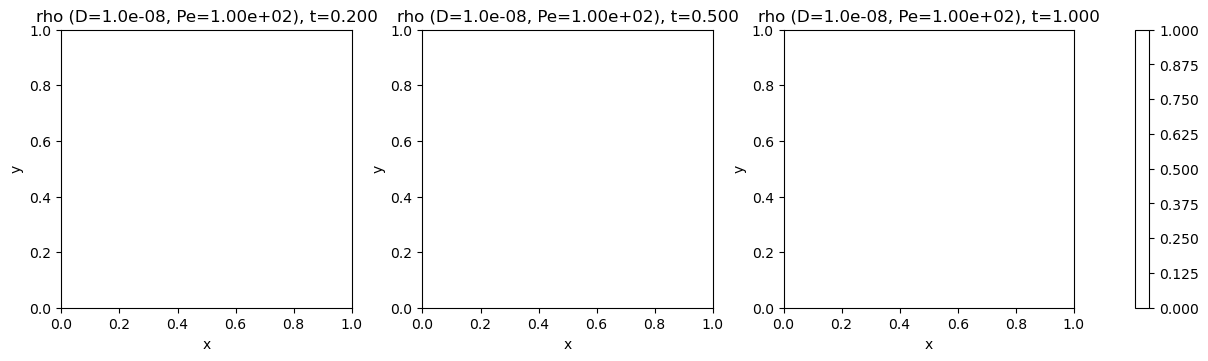

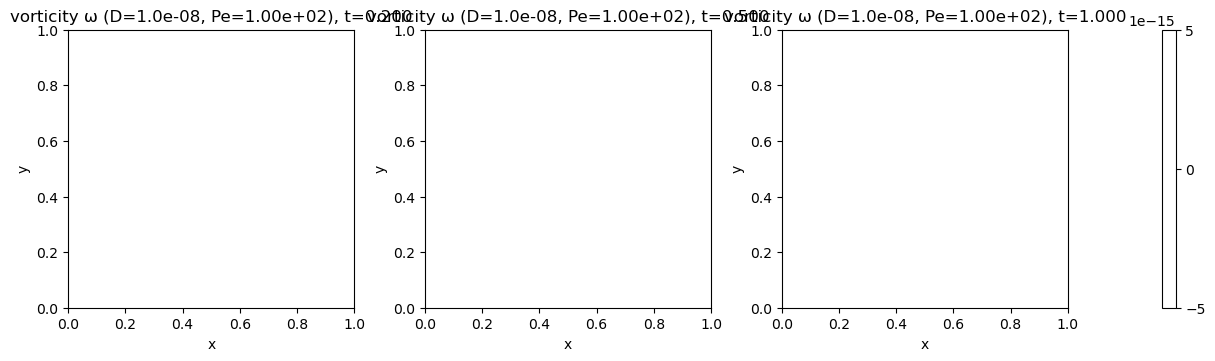

D=2.0e-08 -> Re=1.000e+00, Pe=5.000e+01


KeyboardInterrupt: 

In [100]:
def run_case(prm: RBCParams) -> Dict[str, np.ndarray]:
    solver = RBCSimpleSolver(prm)

    t = 0.0
    nsteps = int(np.ceil(prm.t_end / prm.dt))

    snaps = sorted(list(prm.snapshots))
    snap_ptr = 0

    out = {
        "x": solver.x,
        "y": solver.y,
        "t_snap": [],
        "u_snap": [],
        "v_snap": [],
        "p_snap": [],
        "rho_snap": [],
        "w_snap": [],
        "div_norm": [],
    }

    for n in range(nsteps):
        divn = solver.step()
        t = (n + 1) * prm.dt
        out["div_norm"].append(divn)

        if snap_ptr < len(snaps) and (t >= snaps[snap_ptr] - 0.5*prm.dt):
            w = vorticity(solver.u, solver.v, solver.dx, solver.dy)
            out["t_snap"].append(t)
            out["u_snap"].append(solver.u.copy())
            out["v_snap"].append(solver.v.copy())
            out["p_snap"].append(solver.p.copy())
            out["rho_snap"].append(solver.rho.copy())
            out["w_snap"].append(w.copy())
            snap_ptr += 1

    # convertir a arrays
    out["t_snap"] = np.array(out["t_snap"], dtype=float)
    out["u_snap"] = np.array(out["u_snap"], dtype=float)
    out["v_snap"] = np.array(out["v_snap"], dtype=float)
    out["p_snap"] = np.array(out["p_snap"], dtype=float)
    out["rho_snap"] = np.array(out["rho_snap"], dtype=float)
    out["w_snap"] = np.array(out["w_snap"], dtype=float)
    out["div_norm"] = np.array(out["div_norm"], dtype=float)

    return out


D_list = [1e-8, 2e-8, 4e-8 ]

for Dphys in D_list:
    prm = RBCParams(
        Nx=60, Ny=60,
        Lx=1.0, Ly=1.0,
        u_ref=1e-4,     
        x_ref=1e-2,     
        nu=1e-6,       
        D=Dphys,      
        g=1.0,
        dt=1e-2,
        t_end=1.0,
        simple_iters=30,
        simple_tol=1e-6,
        omega_relax_p=0.7,
        omega_relax_u=0.7,
        snapshots=(0.2, 0.5, 1.0),
    )

    print(f"D={prm.D:.1e} -> Re={prm.Re:.3e}, Pe={prm.Pe:.3e}")

    res = run_case(prm)

    plot_field_snapshots(res["x"], res["y"], res["rho_snap"], res["t_snap"],
                            title_prefix=f"rho (D={prm.D:.1e}, Pe={prm.Pe:.2e})",
                            ncols=3, levels=40)

    plot_field_snapshots(res["x"], res["y"], res["w_snap"], res["t_snap"],
                            title_prefix=f"vorticity ω (D={prm.D:.1e}, Pe={prm.Pe:.2e})",
                            ncols=3, levels=40)
